In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

import pyspark
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.classification import SVMWithSGD, SVMModel

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
from sklearn.metrics import coverage_error
import sklearn.metrics
from gensim.models.doc2vec import Doc2Vec, LabeledSentence
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import logging
from logging import info
from functools import partial

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
IS_SAMPLE = True

In [4]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234

In [5]:
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
MIN_WORD_COUNT = 5
MIN_SIZE = 0
NUM_CORES = 7

In [6]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL', 'SVM_MODEL_NAME'])

In [7]:
SAMPLE_RATIO = 0.0001

In [8]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
METRICS = "metrics.pkl"

In [9]:
#training_file = "/home/local/shalaby/docs_output_sample_100.json"

save_parent_location = "hdfs://deka.cip.ifi.lmu.de/pg-vectors/"
if IS_SAMPLE: 
    save_parent_location = save_parent_location + "sample_" + str(SAMPLE_RATIO) + "/"


root_location = "/home/local/shalaby/"
exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(root_location, "parameter_search_doc2vec_models", "sample_" + str(SAMPLE_RATIO))
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

#training_file = root_location + "docs_output.json"
training_file = root_location + 'docs_output_training_validation_documents_' + str(SAMPLE_RATIO)

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_documents_" + str(SAMPLE_RATIO) + "_sample.pkl"
validation_docs_list_file = exports_location + "validation_documents_" + str(SAMPLE_RATIO) + "_sample.pkl"

In [10]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))

CPU times: user 23.3 s, sys: 1.14 s, total: 24.5 s
Wall time: 24.5 s


In [11]:
len(training_docs_list)

8979

In [12]:
len(validation_docs_list)

1969

In [13]:
def stemtokenizer(text):
    """ MAIN FUNCTION to get clean stems out of a text. A list of clean stems are returned """
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    tokens = tokenizer.tokenize(text)
    stems = []  # result
    for token in tokens:
        stem = token.lower()
        stem = stem.strip(string.punctuation)
        if stem:
            if is_number(stem):
                stem = NUMBER_INDICATOR
            elif is_currency(stem):
                stem = CURRENCY_INDICATOR
            elif is_chemical(stem):
                stem = CHEMICAL_INDICATOR
            else:
                stem = stem.strip(string.punctuation)
            if stem and len(stem) >= MIN_SIZE:
                # extract uni-grams
                stems.append(stem)
    del tokens
    return stems

def is_number(str):
    """ Returns true if given string is a number (float or int)"""
    try:
        float(str.replace(",", ""))
        return True
    except ValueError:
        return False

def is_currency(str):
    return str[0] == "$"

def is_chemical(str):
    return str.count("-") > 3

In [14]:
def get_training_vector(classification, term_list, classifications, number_of_terms):
    clss = 1 if classification in classifications else 0
    return LabeledPoint(clss, SparseVector(number_of_terms, term_list))

def train_level_new(docs_index, classification, doc_classification_map, number_of_terms):
    training_vectors = docs_index.map(
        lambda (doc_id, postings): get_training_vector(classification, postings,
                                                        doc_classification_map[doc_id], number_of_terms))
    svm = SVMWithSGD.train(training_vectors, iterations=SVM_ITERATIONS, convergenceTol=SVM_CONVERGENCE, regParam=SVM_REG)
    return training_vectors, svm

get_binary = lambda x: 1 if x > 0 else 0
get_binary = np.vectorize(get_binary)


def get_top_N_percentage(y_score, y_true, max_N=3):
    """
    Get percentage of correct labels that are in the top N scores
    """
    num_all_true = 0
    num_found_in_max_N = 0
    for i in xrange(y_score.shape[0]):
        y_score_row = y_score[i,:]
        y_true_row = y_true[i,:]
        desc_score_indices = np.argsort(y_score_row)[::-1]
        true_indices = np.where(y_true_row ==1)[0]
        
        num_true_in_row = len(true_indices)
        num_all_true += num_true_in_row
        for i, score_index in enumerate(desc_score_indices):
            # only iterate through the score list till depth N, but make sure you also account for the case where 
            # the number of true labels for the current row is higher than N
            if i >= max_N and i >= num_true_in_row:
                break
            if score_index in true_indices:
                num_found_in_max_N += 1
    return float(num_found_in_max_N)/ num_all_true


def get_metrics(y_true, y_score, y_binary_score):
    metrics = {}
    metrics['total_positive'] = np.sum(np.sum(y_binary_score))
    #TODO remove those two when running on the whole set to avoid excessive storage costs
    metrics['y_true'] = y_true
    metrics['y_score'] = y_score
    metrics['y_binary_score'] = y_binary_score
    metrics['coverage_error'] = coverage_error(y_true, y_binary_score)
    metrics['average_num_of_labels'] = np.sum(np.sum(y_true, axis=1))/y_true.shape[0]
    metrics['average_precision_micro'] = sklearn.metrics.average_precision_score(y_true, y_binary_score, average='micro')
    metrics['average_precision_macro'] = sklearn.metrics.average_precision_score(y_true, y_binary_score, average='macro')
    metrics['precision_micro'] = sklearn.metrics.precision_score(y_true, y_binary_score, average='micro')
    metrics['precision_macro'] = sklearn.metrics.precision_score(y_true, y_binary_score, average='macro')
    metrics['recall_micro'] = sklearn.metrics.recall_score(y_true, y_binary_score, average='micro')
    metrics['recall_macro'] = sklearn.metrics.recall_score(y_true, y_binary_score, average='macro')
    metrics['f1_micro'] = sklearn.metrics.f1_score(y_true, y_binary_score, average='micro')
    metrics['f1_macro'] = sklearn.metrics.f1_score(y_true, y_binary_score, average='macro')

    precision_scores = np.zeros(y_true.shape[1])
    for i in range(0, y_true.shape[1]):
        precision_scores[i] = sklearn.metrics.precision_score(y_true[:,i], y_binary_score[:,i])
    metrics['precision_scores_array'] = precision_scores.tolist()

    recall_scores = np.zeros(y_true.shape[1])
    for i in range(0, y_true.shape[1]):
        recall_scores[i] = sklearn.metrics.recall_score(y_true[:,i], y_binary_score[:,i])
    metrics['recall_scores_array'] = recall_scores.tolist()

    f1_scores = np.zeros(y_true.shape[1])
    for i in range(0, y_true.shape[1]):
        f1_scores[i] = sklearn.metrics.f1_score(y_true[:,i], y_binary_score[:,i])
    metrics['f1_scores_array'] = f1_scores.tolist()

    metrics['top_1'] = get_top_N_percentage(y_score, y_true, max_N=1)
    metrics['top_3'] = get_top_N_percentage(y_score, y_true, max_N=3)
    metrics['top_5'] = get_top_N_percentage(y_score, y_true, max_N=5)
    
    return metrics

def model_exists(path):
    try:
        model = SVMModel.load(sc, path)
        return True;
    except:
        return False
    
def get_training_vector(classification, dense_vector, classifications):
    clss = 1 if classification in classifications else 0
    return LabeledPoint(clss, dense_vector)

def train_level_doc2vec(classification, doc_classification_map):
    doc2vec_model = GLOBAL_VARS.DOC2VEC_MODEL
    training_vectors = []
    for doc_id in training_docs_list:
        # converting from memmap to a normal array as spark is unable to convert memmap to a spark Vector
        normal_array = []
        normal_array[:] = doc2vec_model.docvecs[doc_id][:]
        training_vectors.append(get_training_vector(classification, normal_array, 
                                                    doc_classification_map[doc_id]))
    info("Finished getting training vectors")
    training_vectors = sc.parallelize(training_vectors)
    info("Finished parallelization")
    svm = SVMWithSGD.train(training_vectors, iterations=SVM_ITERATIONS, convergenceTol=SVM_CONVERGENCE, regParam=SVM_REG)
    return training_vectors, svm

In [15]:
def ensure_hdfs_location_exists(location):
    parent = os.path.dirname(location)
    os.system("hdfs dfs -mkdir -p " + location)

def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [16]:
def train_classifications(classifications):
    info("====== Doing Training")
    i=0
    for classification in classifications:
        print classification
        try:
            model_path = get_svm_model_path(GLOBAL_VARS.MODEL_NAME, classification)
            if not model_exists(model_path):
                training_vectors, svm = train_level_doc2vec(classification, doc_classification_map)
                svm.save(sc, model_path)
            else:
                print "Model Exists"
        except:
            print "Problem creating: %s: %s" % (classification, GLOBAL_VARS.MODEL_NAME)
            raise

In [17]:
def do_validation(validation_vectors_matrix, doc_classification_map, classifications, classifications_name):

    info("====== Doing Validation")
    method = GLOBAL_VARS.MODEL_NAME
    subset = classifications_name

    doc_count = validation_vectors_matrix.shape[0]
    y_score = np.zeros((doc_count, len(classifications)))
    y_true = np.zeros((doc_count, len(classifications)))
    i=0

    for classification in classifications:
        print classification

        validation_vectors = get_validation_doc2vec_spark_vectors(validation_vectors_matrix, 
                                                                  classification, doc_classification_map)
        #global binarySvm
        binarySvm = SVMModel.load(sc, get_svm_model_path(GLOBAL_VARS.MODEL_NAME, classification))
        info("Loaded the model, Doing the prediction now....")
        binarySvm.clearThreshold()
        binarySvmB = sc.broadcast(binarySvm)
        # using the broadcasted binarySvm variable, fixes global name 'binarySvm' is not defined as this variable was not
        # available in the workers, so we pass it explicitly to the mapper using partial
        labels_predictions = validation_vectors.map( \
            partial(lambda svm, p: (p.label, svm.value.predict(p.features)), binarySvmB) \
        ).collect()
        #labels = test_labeled_points.map(lambda p: p.labels)
        y_true[:,i] = [label_pred[0] for label_pred in labels_predictions]
        y_score[:,i] = [label_pred[1] for label_pred in labels_predictions]
        i+=1
    y_binary_score = get_binary(y_score)
    # results[method]["y_true"] = y_true
    # results[method]["y_score"] = y_score
    # results[method]["y_binary_score"] = y_binary_score
    metrics = get_metrics(y_true, y_score, y_binary_score)
    return metrics


In [18]:
def get_validation_docs_with_inference(doc2vec_model, doc_classification_map):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # do inference and store results in dict
        i = 0
        for (doc_id, doc_contents_array) in ValidationDocumentGenerator(training_file, validation_docs_list):
            i += 1
            if i % 1000 == 0: info("Finished: {}".format(str(i)))
            validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)

        # create matrix for the validation vectors
        for validation_doc_id in validation_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            validation_labels.append([classf for classf in doc_classification_map[validation_doc_id] if classf in sections])
        validation_vectors_matrix = np.array(validation_vectors)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix

In [19]:
def get_validation_doc2vec_spark_vectors(validation_vectors_matrix, classification, doc_classification_map):
    validation_vectors = []
    for (index, doc_id) in enumerate(validation_docs_list):
        # converting from memmap to a normal array as spark is unable to convert memmap to a spark Vector
        validation_vector = validation_vectors_matrix[index]
        validation_vectors.append(get_training_vector(classification, validation_vector, 
                                                    doc_classification_map[doc_id]))
    validation_vectors = sc.parallelize(validation_vectors)
    info("Finished getting validation vectors")
    return validation_vectors

In [20]:
class MetricsGraph:
    def __init__(self):
        self.coverage_errors = []
        self.average_num_labels = []
        
        self.f1_micros = []
        self.precision_micros = []
        self.recall_micros = []
        self.f1_macros = []
        self.precision_macros = []
        self.recall_macros = []
        
        self.top_1s = []
        self.top_3s = []
        self.top_5s = []
        
        self.epochs = []
        
        self.fig = None
        self.ax = None
        self.ax2 = None
    
    def init_graph(self):
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(121)
        self.ax2 = plt.subplot(122)
        self.fig.subplots_adjust(top=0.72, bottom=0.1, left=0.05, right=0.95)
        self.ax.set_xlabel("Epochs")
        self.ax2.set_xlabel("Epochs")
    
    def _add_metrics(self, metrics, epoch):
        self.coverage_errors.append(metrics['coverage_error'])
        self.average_num_labels.append(metrics['average_num_of_labels'])
        
        self.f1_micros.append(metrics['f1_micro'])
        self.precision_micros.append(metrics['precision_micro'])
        self.recall_micros.append(metrics['recall_micro'])
        self.f1_macros.append(metrics['f1_macro'])
        self.precision_macros.append(metrics['precision_macro'])
        self.recall_macros.append(metrics['recall_macro'])
        
        self.top_1s.append(metrics['top_1']  if 'top_1' in metrics else get_top_N_percentage(metrics['y_score'], metrics['y_true'], max_N=1))
        self.top_3s.append(metrics['top_3']  if 'top_3' in metrics else get_top_N_percentage(metrics['y_score'], metrics['y_true'], max_N=3))
        self.top_5s.append(metrics['top_5']  if 'top_5' in metrics else get_top_N_percentage(metrics['y_score'], metrics['y_true'], max_N=5))
        
        self.epochs.append(epoch)
        
    def add_metrics_to_graph(self, metrics, epoch, draw_now=True):
        
        self._add_metrics(metrics, epoch)
        if draw_now:
            self.draw()

    def draw(self):
        
        first_epoch = self.epochs[0]
        last_epoch = self.epochs[-1]
        
        coverage_error_line, = self.ax.plot(self.epochs, self.coverage_errors, 'r-', label='Coverage Error')
        average_num_labels_line, = self.ax.plot(self.epochs, self.average_num_labels, 'g-', label='Avg Num. of Labels')

        self.ax.legend(handles=[coverage_error_line, average_num_labels_line],
                  bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
        self.ax.axis([first_epoch, last_epoch, 0, 10])
        # show the average number of labels as a separate y-tick
        curr_min_cov = [min(self.coverage_errors)]
        prev_min_cov = [min(self.coverage_errors[:-1])] if len(self.coverage_errors) > 1 else []
        self.ax.set_yticks(list(set(self.ax.get_yticks())- set(prev_min_cov) ) + [self.average_num_labels[0]] + curr_min_cov)

        f1_micro_line, = self.ax2.plot(self.epochs, self.f1_micros, 'g-', label='F1 Micro')
        precision_micro_line, = self.ax2.plot(self.epochs, self.precision_micros, 'r-', label='Precision Micro')
        recall_micro_line, = self.ax2.plot(self.epochs, self.recall_micros, 'b-', label='Recall Micro')
        f1_macro_line, = self.ax2.plot(self.epochs, self.f1_macros, 'g--', label='F1 Macro')
        precision_macro_line, = self.ax2.plot(self.epochs, self.precision_macros, 'r--', label='Precision Macro')
        recall_macro_line, = self.ax2.plot(self.epochs, self.recall_macros, 'b--', label='Recall Macro')
        
        top_1_line, = self.ax2.plot(self.epochs, self.top_1s, 'g-.', label='Top 1 %')
        top_3_line, = self.ax2.plot(self.epochs, self.top_3s, 'r-.', label='Top 3 %')
        top_5_line, = self.ax2.plot(self.epochs, self.top_5s, 'b-.', label='Top 5 %')
        
        self.ax2.legend(handles=[f1_micro_line, precision_micro_line, recall_micro_line, 
                                 f1_macro_line, precision_macro_line, recall_macro_line,
                                 top_1_line, top_3_line, top_5_line],
                  bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
        self.ax2.axis([first_epoch, last_epoch, 0, 1])
        curr_max_f1_micro = [max(self.f1_micros)]
        prev_max_f1_micro = [max(self.f1_micros[:-1])] if len(self.f1_micros) > 1 else []
        self.ax2.set_yticks(list(set(self.ax2.get_yticks())- set(prev_max_f1_micro) ) + curr_max_f1_micro)
        
        self.fig.canvas.draw()

### Doc2vec and SVM Parameters

In [43]:
DOC2VEC_SIZE = 1000
DOC2VEC_WINDOW = 8
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-5
DOC2VEC_TYPE = 2
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 1
DOC2VEC_MEAN = 0
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 20
REPORT_DELAY = 60 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 1000 # report the progress every x terms

In [44]:
SVM_ITERATIONS = 1000
SVM_CONVERGENCE = 0.001
SVM_REG = 0.1
GLOBAL_VARS.SVM_MODEL_NAME = 'iter_{}_reg_{}'.format(SVM_ITERATIONS, SVM_REG)

In [45]:
def get_svm_model_path(method, classification, reg=SVM_REG, iterations=SVM_ITERATIONS):
    location = os.path.join(save_parent_location, "models", method, 
                            "iter_" + str(iterations) + "_reg_" + str(reg),
                            classification + "_model.svm")
    ensure_hdfs_location_exists(location)
    return location

class TrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
                
class ValidationDocumentGenerator(object):
    def __init__(self, filename, validation_docs_list):
        self.filename = filename
        self.validation_docs_list = validation_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.validation_docs_list:
                    yield doc_id, stemtokenizer(text)
                    
class StochasticDocumentGenerator(object):
    def __init__(self, filename, training_docs_list, line_positions):
        self.filename = filename
        self.training_docs_list = training_docs_list
        self.line_positions = line_positions
        self.lines = set(line_positions.keys())
    def __iter__(self):
        with open(self.filename) as file_obj:
            while len(self.lines) > 0:
                random_line = random.sample(self.lines,1)[0]
                self.lines.remove(random_line)
                file_obj.seek(self.line_positions[random_line])
                line = file_obj.readline()
                if not line.strip(): continue
#                 print random_line, self.line_positions[random_line], line[:30]
                (doc_id, text) = eval(line)
                # print random_line , doc_id
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
#                     yield doc_id

#### Get starting positions in bytes for every line to be able to do random sampling

In [36]:
line_positions = dict()
with open(training_file) as f:
    
    i = 0
    line_positions[i] = f.tell()
    line = f.readline()
    while line:
        i+=1
        if not line.strip(): continue
        line_positions[i] = f.tell()
        line = f.readline()
    del line_positions[i]

## Create the Doc2vec model

In [46]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
placeholder_model_name = placeholder_model_name + "_curriter_{}"
placeholder_model_name

'doc2vec_size_1000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_{}'

In [38]:
doc2vec_model = Doc2Vec(size=DOC2VEC_SIZE , window=DOC2VEC_WINDOW, min_count=MIN_WORD_COUNT, 
                max_vocab_size= DOC2VEC_MAX_VOCAB_SIZE,
                sample=DOC2VEC_SAMPLE, seed=DOC2VEC_SEED, workers=NUM_CORES,
                # doc2vec algorithm dm=1 => PV-DM, dm=2 => PV-DBOW, PV-DM dictates CBOW for words
                dm=DOC2VEC_TYPE,
                # hs=0 => negative sampling, hs=1 => hierarchical softmax
                hs=DOC2VEC_HIERARCHICAL_SAMPLE, negative=DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                dm_concat=DOC2VEC_CONCAT,
                # would train words with skip-gram on top of cbow, we don't need that for now
                dbow_words=DOC2VEC_TRAIN_WORDS,
                iter=DOC2VEC_EPOCHS)

GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

In [39]:
%%time
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX)):
    doc2vec_model.build_vocab(sentences=TrainingDocumentGenerator(training_file, training_docs_list), 
                              progress_per=REPORT_VOCAB_PROGRESS)
    doc2vec_model.save(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
else: 
    doc2vec_model_vocab_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
    doc2vec_model.reset_from(doc2vec_model_vocab_model)

2016-09-26 13:57:01,977 : INFO : loading Doc2Vec object from /home/local/shalaby/parameter_search_doc2vec_models/sample_0.0001/vocab_model/model
2016-09-26 13:57:02,627 : INFO : loading docvecs recursively from /home/local/shalaby/parameter_search_doc2vec_models/sample_0.0001/vocab_model/model.docvecs.* with mmap=None
2016-09-26 13:57:02,628 : INFO : loading syn1neg from /home/local/shalaby/parameter_search_doc2vec_models/sample_0.0001/vocab_model/model.syn1neg.npy with mmap=None
2016-09-26 14:00:59,750 : INFO : loading syn0 from /home/local/shalaby/parameter_search_doc2vec_models/sample_0.0001/vocab_model/model.syn0.npy with mmap=None
2016-09-26 14:01:15,492 : INFO : setting ignored attribute syn0norm to None
2016-09-26 14:01:15,493 : INFO : setting ignored attribute cum_table to None
2016-09-26 14:01:15,900 : INFO : resetting layer weights


CPU times: user 7.69 s, sys: 4min 16s, total: 4min 24s
Wall time: 4min 24s


## Actual Training, validation and Metrics Loop

In [40]:
#doc2vec_model.min_alpha = 0.025
epoch_metrics = []

<IPython.core.display.Javascript object>


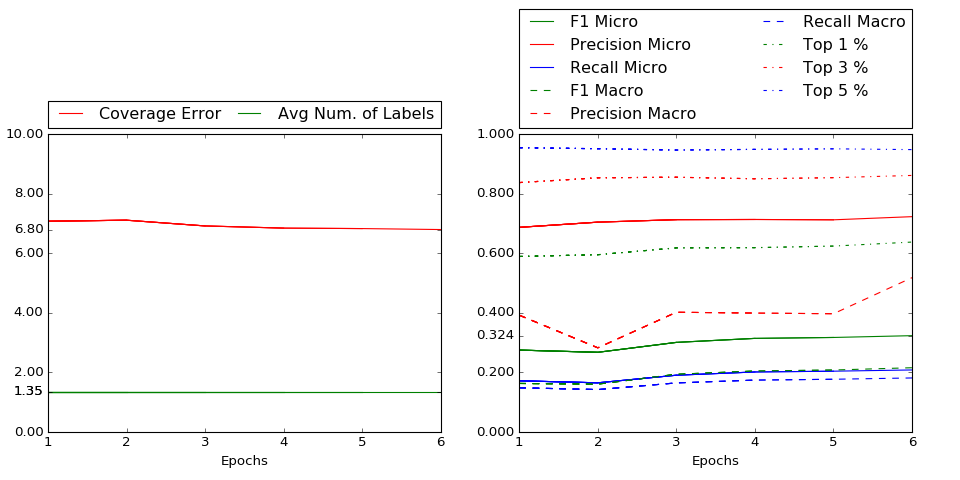

2016-09-26 14:01:45,121 : INFO : ****************** Epoch 1 --- Working on doc2vec_size_3000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_1 *******************
2016-09-26 14:01:45,124 : INFO : training model with 7 workers on 104358 vocabulary and 3000 features, using sg=1 hs=0 sample=1e-05 negative=10
2016-09-26 14:01:45,124 : INFO : expecting 8979 sentences, matching count from corpus used for vocabulary survey
2016-09-26 14:01:46,152 : INFO : PROGRESS: at 0.14% examples, 21039 words/s, in_qsize 0, out_qsize 1
2016-09-26 14:02:46,156 : INFO : PROGRESS: at 10.93% examples, 26996 words/s, in_qsize 0, out_qsize 0
2016-09-26 14:03:46,297 : INFO : PROGRESS: at 21.45% examples, 26955 words/s, in_qsize 0, out_qsize 0
2016-09-26 14:04:46,382 : INFO : PROGRESS: at 32.84% examples, 27423 words/s, in_qsize 1, out_qsize 0
2016-09-26 14:05:46,463 : INFO : PROGRESS: at 44.04% examples, 27424 words/s, in_qsize 0, out_qsize 0
2016-09-26 14:06:46,546 : INFO : PROG

A


2016-09-26 14:10:55,283 : INFO : Finished getting training vectors
2016-09-26 14:10:56,102 : INFO : Finished parallelization


B


2016-09-26 14:15:20,594 : INFO : Finished getting training vectors
2016-09-26 14:15:21,440 : INFO : Finished parallelization


C


2016-09-26 14:18:47,404 : INFO : Finished getting training vectors
2016-09-26 14:18:48,211 : INFO : Finished parallelization


D


2016-09-26 14:23:16,969 : INFO : Finished getting training vectors
2016-09-26 14:23:17,762 : INFO : Finished parallelization


E


2016-09-26 14:29:33,770 : INFO : Finished getting training vectors
2016-09-26 14:29:34,698 : INFO : Finished parallelization


F


2016-09-26 14:35:32,392 : INFO : Finished getting training vectors
2016-09-26 14:35:33,259 : INFO : Finished parallelization


G


2016-09-26 14:39:31,111 : INFO : Finished getting training vectors
2016-09-26 14:39:31,883 : INFO : Finished parallelization


H


2016-09-26 14:43:09,903 : INFO : Finished getting training vectors
2016-09-26 14:43:10,671 : INFO : Finished parallelization
2016-09-26 14:47:14,759 : INFO : ===== Getting validation vectors with inference
2016-09-26 14:51:43,930 : INFO : Finished: 1000
2016-09-26 14:56:09,766 : INFO : ====== Doing Validation


A


2016-09-26 14:56:10,013 : INFO : Finished getting validation vectors
2016-09-26 14:56:10,939 : INFO : Loaded the model, Doing the prediction now....


B


2016-09-26 14:56:11,710 : INFO : Finished getting validation vectors
2016-09-26 14:56:12,453 : INFO : Loaded the model, Doing the prediction now....


C


2016-09-26 14:56:13,050 : INFO : Finished getting validation vectors
2016-09-26 14:56:13,791 : INFO : Loaded the model, Doing the prediction now....


D


2016-09-26 14:56:14,381 : INFO : Finished getting validation vectors
2016-09-26 14:56:15,045 : INFO : Loaded the model, Doing the prediction now....


E


2016-09-26 14:56:15,720 : INFO : Finished getting validation vectors
2016-09-26 14:56:16,426 : INFO : Loaded the model, Doing the prediction now....


F


2016-09-26 14:56:17,047 : INFO : Finished getting validation vectors
2016-09-26 14:56:17,751 : INFO : Loaded the model, Doing the prediction now....


G


2016-09-26 14:56:18,372 : INFO : Finished getting validation vectors
2016-09-26 14:56:19,104 : INFO : Loaded the model, Doing the prediction now....


H


2016-09-26 14:56:19,737 : INFO : Finished getting validation vectors
2016-09-26 14:56:20,482 : INFO : Loaded the model, Doing the prediction now....


Coverage Error: 7.08278313865, Average No of Labels: 1.35195530726, Top 1: 0.589782118708, Top 3: 0.838091660406, Top 5: 0.955296769346, F1 Micro: 0.275240384615, Total Positive: 666


2016-09-26 14:56:21,344 : INFO : ****************** Epoch 2 --- Working on doc2vec_size_3000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_2 *******************
2016-09-26 14:56:21,347 : INFO : training model with 7 workers on 104358 vocabulary and 3000 features, using sg=1 hs=0 sample=1e-05 negative=10
2016-09-26 14:56:21,348 : INFO : expecting 8979 sentences, matching count from corpus used for vocabulary survey
2016-09-26 14:56:22,371 : INFO : PROGRESS: at 0.13% examples, 21184 words/s, in_qsize 0, out_qsize 0
2016-09-26 14:57:22,495 : INFO : PROGRESS: at 10.93% examples, 26699 words/s, in_qsize 0, out_qsize 0
2016-09-26 14:58:22,457 : INFO : PROGRESS: at 21.08% examples, 26479 words/s, in_qsize 0, out_qsize 0
2016-09-26 14:59:22,469 : INFO : PROGRESS: at 32.46% examples, 26880 words/s, in_qsize 0, out_qsize 0
2016-09-26 15:00:22,470 : INFO : PROGRESS: at 42.86% examples, 27018 words/s, in_qsize 0, out_qsize 0
2016-09-26 15:01:22,620 : INFO : PROG

A


2016-09-26 15:05:38,258 : INFO : Finished getting training vectors
2016-09-26 15:05:39,412 : INFO : Finished parallelization


B


2016-09-26 15:10:02,556 : INFO : Finished getting training vectors
2016-09-26 15:10:03,409 : INFO : Finished parallelization


C


2016-09-26 15:13:34,163 : INFO : Finished getting training vectors
2016-09-26 15:13:35,035 : INFO : Finished parallelization


D


2016-09-26 15:17:48,535 : INFO : Finished getting training vectors
2016-09-26 15:17:49,498 : INFO : Finished parallelization


E


2016-09-26 15:23:08,710 : INFO : Finished getting training vectors
2016-09-26 15:23:09,617 : INFO : Finished parallelization


F


2016-09-26 15:27:36,473 : INFO : Finished getting training vectors
2016-09-26 15:27:37,321 : INFO : Finished parallelization


G


2016-09-26 15:31:30,001 : INFO : Finished getting training vectors
2016-09-26 15:31:30,821 : INFO : Finished parallelization


H


2016-09-26 15:34:51,040 : INFO : Finished getting training vectors
2016-09-26 15:34:51,892 : INFO : Finished parallelization
2016-09-26 15:38:48,690 : INFO : ===== Getting validation vectors with inference
2016-09-26 15:43:20,772 : INFO : Finished: 1000
2016-09-26 15:47:43,085 : INFO : ====== Doing Validation


A


2016-09-26 15:47:43,382 : INFO : Finished getting validation vectors
2016-09-26 15:47:44,139 : INFO : Loaded the model, Doing the prediction now....


B


2016-09-26 15:47:45,086 : INFO : Finished getting validation vectors
2016-09-26 15:47:45,846 : INFO : Loaded the model, Doing the prediction now....


C


2016-09-26 15:47:46,506 : INFO : Finished getting validation vectors
2016-09-26 15:47:47,214 : INFO : Loaded the model, Doing the prediction now....


D


2016-09-26 15:47:47,825 : INFO : Finished getting validation vectors
2016-09-26 15:47:48,521 : INFO : Loaded the model, Doing the prediction now....


E


2016-09-26 15:47:49,186 : INFO : Finished getting validation vectors
2016-09-26 15:47:49,911 : INFO : Loaded the model, Doing the prediction now....


F


2016-09-26 15:47:50,547 : INFO : Finished getting validation vectors
2016-09-26 15:47:51,302 : INFO : Loaded the model, Doing the prediction now....


G


2016-09-26 15:47:51,934 : INFO : Finished getting validation vectors
2016-09-26 15:47:52,679 : INFO : Loaded the model, Doing the prediction now....


H


2016-09-26 15:47:53,317 : INFO : Finished getting validation vectors
2016-09-26 15:47:53,996 : INFO : Loaded the model, Doing the prediction now....
2016-09-26 15:47:54,820 : INFO : ****************** Epoch 3 --- Working on doc2vec_size_3000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_3 *******************
2016-09-26 15:47:54,823 : INFO : training model with 7 workers on 104358 vocabulary and 3000 features, using sg=1 hs=0 sample=1e-05 negative=10
2016-09-26 15:47:54,824 : INFO : expecting 8979 sentences, matching count from corpus used for vocabulary survey


Coverage Error: 7.11681056374, Average No of Labels: 1.35195530726, Top 1: 0.595792637115, Top 3: 0.854244928625, Top 5: 0.951915852742, F1 Micro: 0.267802799757, Total Positive: 624


2016-09-26 15:47:55,891 : INFO : PROGRESS: at 0.14% examples, 20088 words/s, in_qsize 0, out_qsize 0
2016-09-26 15:48:56,011 : INFO : PROGRESS: at 11.42% examples, 27389 words/s, in_qsize 0, out_qsize 0
2016-09-26 15:49:56,050 : INFO : PROGRESS: at 22.61% examples, 28036 words/s, in_qsize 0, out_qsize 0
2016-09-26 15:50:56,141 : INFO : PROGRESS: at 34.31% examples, 28021 words/s, in_qsize 0, out_qsize 0
2016-09-26 15:51:56,257 : INFO : PROGRESS: at 45.19% examples, 27859 words/s, in_qsize 0, out_qsize 0
2016-09-26 15:52:56,437 : INFO : PROGRESS: at 55.71% examples, 27641 words/s, in_qsize 0, out_qsize 0
2016-09-26 15:53:56,471 : INFO : PROGRESS: at 66.86% examples, 27709 words/s, in_qsize 0, out_qsize 0
2016-09-26 15:54:56,467 : INFO : PROGRESS: at 78.44% examples, 27785 words/s, in_qsize 0, out_qsize 0
2016-09-26 15:55:56,527 : INFO : PROGRESS: at 89.88% examples, 27861 words/s, in_qsize 0, out_qsize 0
2016-09-26 15:56:48,934 : INFO : worker thread finished; awaiting finish of 6 more 

A


2016-09-26 15:57:00,211 : INFO : Finished getting training vectors
2016-09-26 15:57:02,208 : INFO : Finished parallelization


B


2016-09-26 16:17:06,613 : INFO : Finished getting training vectors
2016-09-26 16:17:07,534 : INFO : Finished parallelization


C


2016-09-26 16:21:51,084 : INFO : Finished getting training vectors
2016-09-26 16:21:52,047 : INFO : Finished parallelization


D


2016-09-26 16:26:10,379 : INFO : Finished getting training vectors
2016-09-26 16:26:11,315 : INFO : Finished parallelization


E


2016-09-26 16:53:33,300 : INFO : Finished getting training vectors
2016-09-26 16:53:36,934 : INFO : Finished parallelization


F


2016-09-26 17:12:15,277 : INFO : Finished getting training vectors
2016-09-26 17:12:16,263 : INFO : Finished parallelization


G


2016-09-26 17:32:08,309 : INFO : Finished getting training vectors
2016-09-26 17:32:09,285 : INFO : Finished parallelization


H


2016-09-26 17:37:55,296 : INFO : Finished getting training vectors
2016-09-26 17:37:56,214 : INFO : Finished parallelization
2016-09-26 18:16:31,953 : INFO : ===== Getting validation vectors with inference
2016-09-26 18:20:56,418 : INFO : Finished: 1000
2016-09-26 18:25:18,276 : INFO : ====== Doing Validation


A


2016-09-26 18:25:18,548 : INFO : Finished getting validation vectors
2016-09-26 18:25:19,349 : INFO : Loaded the model, Doing the prediction now....


B


2016-09-26 18:25:21,929 : INFO : Finished getting validation vectors
2016-09-26 18:25:22,719 : INFO : Loaded the model, Doing the prediction now....


C


2016-09-26 18:25:23,465 : INFO : Finished getting validation vectors
2016-09-26 18:25:24,225 : INFO : Loaded the model, Doing the prediction now....


D


2016-09-26 18:25:25,237 : INFO : Finished getting validation vectors
2016-09-26 18:25:25,989 : INFO : Loaded the model, Doing the prediction now....


E


2016-09-26 18:25:26,648 : INFO : Finished getting validation vectors
2016-09-26 18:25:27,410 : INFO : Loaded the model, Doing the prediction now....


F


2016-09-26 18:25:28,130 : INFO : Finished getting validation vectors
2016-09-26 18:25:28,891 : INFO : Loaded the model, Doing the prediction now....


G


2016-09-26 18:25:29,571 : INFO : Finished getting validation vectors
2016-09-26 18:25:30,364 : INFO : Loaded the model, Doing the prediction now....


H


2016-09-26 18:25:31,002 : INFO : Finished getting validation vectors
2016-09-26 18:25:31,755 : INFO : Loaded the model, Doing the prediction now....


Coverage Error: 6.92432706958, Average No of Labels: 1.35195530726, Top 1: 0.618707738542, Top 3: 0.856123215627, Top 5: 0.947407963937, F1 Micro: 0.301126259632, Total Positive: 712


2016-09-26 18:25:32,634 : INFO : ****************** Epoch 4 --- Working on doc2vec_size_3000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_4 *******************
2016-09-26 18:25:32,637 : INFO : training model with 7 workers on 104358 vocabulary and 3000 features, using sg=1 hs=0 sample=1e-05 negative=10
2016-09-26 18:25:32,637 : INFO : expecting 8979 sentences, matching count from corpus used for vocabulary survey
2016-09-26 18:25:33,736 : INFO : PROGRESS: at 0.13% examples, 21261 words/s, in_qsize 0, out_qsize 0
2016-09-26 18:26:33,750 : INFO : PROGRESS: at 10.76% examples, 26368 words/s, in_qsize 0, out_qsize 0
2016-09-26 18:27:33,794 : INFO : PROGRESS: at 22.55% examples, 27224 words/s, in_qsize 0, out_qsize 1
2016-09-26 18:28:33,860 : INFO : PROGRESS: at 33.62% examples, 27619 words/s, in_qsize 0, out_qsize 0
2016-09-26 18:29:33,902 : INFO : PROGRESS: at 44.95% examples, 27616 words/s, in_qsize 0, out_qsize 0
2016-09-26 18:30:33,906 : INFO : PROG

A


2016-09-26 18:34:36,477 : INFO : Finished getting training vectors
2016-09-26 18:34:37,806 : INFO : Finished parallelization


B


2016-09-26 19:19:02,107 : INFO : Finished getting training vectors
2016-09-26 19:19:03,214 : INFO : Finished parallelization


C


2016-09-26 20:18:25,836 : INFO : Finished getting training vectors
2016-09-26 20:18:27,775 : INFO : Finished parallelization


D


2016-09-26 21:28:07,069 : INFO : Finished getting training vectors
2016-09-26 21:28:09,653 : INFO : Finished parallelization


E


2016-09-26 21:41:50,322 : INFO : Finished getting training vectors
2016-09-26 21:41:51,338 : INFO : Finished parallelization


F


2016-09-26 21:54:35,278 : INFO : Finished getting training vectors
2016-09-26 21:54:36,200 : INFO : Finished parallelization


G


2016-09-26 22:54:05,040 : INFO : Finished getting training vectors
2016-09-26 22:54:07,133 : INFO : Finished parallelization


H


2016-09-26 23:59:07,906 : INFO : Finished getting training vectors
2016-09-26 23:59:13,342 : INFO : Finished parallelization
2016-09-27 01:22:45,681 : INFO : ===== Getting validation vectors with inference
2016-09-27 01:27:08,856 : INFO : Finished: 1000
2016-09-27 01:31:29,044 : INFO : ====== Doing Validation


A


2016-09-27 01:31:29,329 : INFO : Finished getting validation vectors
2016-09-27 01:31:30,112 : INFO : Loaded the model, Doing the prediction now....


B


2016-09-27 01:31:31,052 : INFO : Finished getting validation vectors
2016-09-27 01:31:31,777 : INFO : Loaded the model, Doing the prediction now....


C


2016-09-27 01:31:32,972 : INFO : Finished getting validation vectors
2016-09-27 01:31:33,738 : INFO : Loaded the model, Doing the prediction now....


D


2016-09-27 01:31:34,384 : INFO : Finished getting validation vectors
2016-09-27 01:31:35,135 : INFO : Loaded the model, Doing the prediction now....


E


2016-09-27 01:31:35,747 : INFO : Finished getting validation vectors
2016-09-27 01:31:36,481 : INFO : Loaded the model, Doing the prediction now....


F


2016-09-27 01:31:37,161 : INFO : Finished getting validation vectors
2016-09-27 01:31:37,963 : INFO : Loaded the model, Doing the prediction now....


G


2016-09-27 01:31:38,672 : INFO : Finished getting validation vectors
2016-09-27 01:31:39,419 : INFO : Loaded the model, Doing the prediction now....


H


2016-09-27 01:31:40,092 : INFO : Finished getting validation vectors
2016-09-27 01:31:40,847 : INFO : Loaded the model, Doing the prediction now....
2016-09-27 01:31:41,618 : INFO : ****************** Epoch 5 --- Working on doc2vec_size_3000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_5 *******************
2016-09-27 01:31:41,621 : INFO : training model with 7 workers on 104358 vocabulary and 3000 features, using sg=1 hs=0 sample=1e-05 negative=10
2016-09-27 01:31:41,621 : INFO : expecting 8979 sentences, matching count from corpus used for vocabulary survey


Coverage Error: 6.85119349924, Average No of Labels: 1.35195530726, Top 1: 0.619459053343, Top 3: 0.850864012021, Top 5: 0.94966190834, F1 Micro: 0.314586994728, Total Positive: 752


2016-09-27 01:31:42,694 : INFO : PROGRESS: at 0.17% examples, 12395 words/s, in_qsize 0, out_qsize 0
2016-09-27 01:32:42,698 : INFO : PROGRESS: at 11.60% examples, 27146 words/s, in_qsize 0, out_qsize 0
2016-09-27 01:33:42,787 : INFO : PROGRESS: at 22.49% examples, 27401 words/s, in_qsize 0, out_qsize 0
2016-09-27 01:34:42,850 : INFO : PROGRESS: at 33.81% examples, 27541 words/s, in_qsize 0, out_qsize 0
2016-09-27 01:35:42,945 : INFO : PROGRESS: at 45.41% examples, 27739 words/s, in_qsize 0, out_qsize 0
2016-09-27 01:36:42,981 : INFO : PROGRESS: at 56.73% examples, 27866 words/s, in_qsize 0, out_qsize 0
2016-09-27 01:37:43,027 : INFO : PROGRESS: at 67.69% examples, 27928 words/s, in_qsize 0, out_qsize 0
2016-09-27 01:38:43,083 : INFO : PROGRESS: at 78.78% examples, 27909 words/s, in_qsize 0, out_qsize 1
2016-09-27 01:39:43,140 : INFO : PROGRESS: at 90.17% examples, 27941 words/s, in_qsize 0, out_qsize 1
2016-09-27 01:40:36,641 : INFO : worker thread finished; awaiting finish of 6 more 

A


2016-09-27 01:40:49,712 : INFO : Finished getting training vectors
2016-09-27 01:40:52,924 : INFO : Finished parallelization


B


2016-09-27 02:44:46,085 : INFO : Finished getting training vectors
2016-09-27 02:44:50,522 : INFO : Finished parallelization


C


2016-09-27 03:53:54,985 : INFO : Finished getting training vectors
2016-09-27 03:53:59,116 : INFO : Finished parallelization


D


2016-09-27 05:14:43,885 : INFO : Finished getting training vectors
2016-09-27 05:14:44,886 : INFO : Finished parallelization


E


2016-09-27 05:28:38,777 : INFO : Finished getting training vectors
2016-09-27 05:28:39,788 : INFO : Finished parallelization


F


2016-09-27 05:34:30,838 : INFO : Finished getting training vectors
2016-09-27 05:34:31,765 : INFO : Finished parallelization


G


2016-09-27 05:40:02,443 : INFO : Finished getting training vectors
2016-09-27 05:40:03,357 : INFO : Finished parallelization


H


2016-09-27 05:45:57,832 : INFO : Finished getting training vectors
2016-09-27 05:45:58,820 : INFO : Finished parallelization
2016-09-27 06:45:40,587 : INFO : ===== Getting validation vectors with inference
2016-09-27 06:50:02,162 : INFO : Finished: 1000
2016-09-27 06:54:18,763 : INFO : ====== Doing Validation


A


2016-09-27 06:54:19,022 : INFO : Finished getting validation vectors
2016-09-27 06:54:19,807 : INFO : Loaded the model, Doing the prediction now....


B


2016-09-27 06:54:20,532 : INFO : Finished getting validation vectors
2016-09-27 06:54:21,344 : INFO : Loaded the model, Doing the prediction now....


C


2016-09-27 06:54:21,960 : INFO : Finished getting validation vectors
2016-09-27 06:54:22,668 : INFO : Loaded the model, Doing the prediction now....


D


2016-09-27 06:54:23,339 : INFO : Finished getting validation vectors
2016-09-27 06:54:24,137 : INFO : Loaded the model, Doing the prediction now....


E


2016-09-27 06:54:24,819 : INFO : Finished getting validation vectors
2016-09-27 06:54:25,611 : INFO : Loaded the model, Doing the prediction now....


F


2016-09-27 06:54:26,252 : INFO : Finished getting validation vectors
2016-09-27 06:54:26,999 : INFO : Loaded the model, Doing the prediction now....


G


2016-09-27 06:54:27,676 : INFO : Finished getting validation vectors
2016-09-27 06:54:28,418 : INFO : Loaded the model, Doing the prediction now....


H


2016-09-27 06:54:29,076 : INFO : Finished getting validation vectors
2016-09-27 06:54:29,858 : INFO : Loaded the model, Doing the prediction now....


Coverage Error: 6.83544946673, Average No of Labels: 1.35195530726, Top 1: 0.62471825695, Top 3: 0.854620586026, Top 5: 0.951540195342, F1 Micro: 0.317664233577, Total Positive: 763


2016-09-27 06:54:30,698 : INFO : ****************** Epoch 6 --- Working on doc2vec_size_3000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_6 *******************
2016-09-27 06:54:30,700 : INFO : training model with 7 workers on 104358 vocabulary and 3000 features, using sg=1 hs=0 sample=1e-05 negative=10
2016-09-27 06:54:30,701 : INFO : expecting 8979 sentences, matching count from corpus used for vocabulary survey
2016-09-27 06:54:31,789 : INFO : PROGRESS: at 0.19% examples, 19115 words/s, in_qsize 0, out_qsize 0
2016-09-27 06:55:31,804 : INFO : PROGRESS: at 11.50% examples, 27983 words/s, in_qsize 0, out_qsize 0
2016-09-27 06:56:32,052 : INFO : PROGRESS: at 22.68% examples, 27172 words/s, in_qsize 0, out_qsize 0
2016-09-27 06:57:32,060 : INFO : PROGRESS: at 33.90% examples, 27517 words/s, in_qsize 0, out_qsize 0
2016-09-27 06:58:32,145 : INFO : PROGRESS: at 45.01% examples, 27661 words/s, in_qsize 0, out_qsize 0
2016-09-27 06:59:32,269 : INFO : PROG

A


2016-09-27 07:03:40,833 : INFO : Finished getting training vectors
2016-09-27 07:03:48,106 : INFO : Finished parallelization


B


2016-09-27 07:41:49,268 : INFO : Finished getting training vectors
2016-09-27 07:41:50,260 : INFO : Finished parallelization


C


2016-09-27 08:00:49,830 : INFO : Finished getting training vectors
2016-09-27 08:00:50,880 : INFO : Finished parallelization


D


2016-09-27 08:16:44,927 : INFO : Finished getting training vectors
2016-09-27 08:16:45,801 : INFO : Finished parallelization


E


2016-09-27 08:40:11,277 : INFO : Finished getting training vectors
2016-09-27 08:40:12,231 : INFO : Finished parallelization


F


2016-09-27 09:01:13,650 : INFO : Finished getting training vectors
2016-09-27 09:01:14,653 : INFO : Finished parallelization


G


2016-09-27 09:47:14,286 : INFO : Finished getting training vectors
2016-09-27 09:47:15,151 : INFO : Finished parallelization


H


2016-09-27 10:43:48,409 : INFO : Finished getting training vectors
2016-09-27 10:43:49,339 : INFO : Finished parallelization
2016-09-27 11:38:47,811 : INFO : ===== Getting validation vectors with inference
2016-09-27 11:43:07,598 : INFO : Finished: 1000
2016-09-27 11:47:24,512 : INFO : ====== Doing Validation


A


2016-09-27 11:47:24,798 : INFO : Finished getting validation vectors
2016-09-27 11:47:25,644 : INFO : Loaded the model, Doing the prediction now....


B


2016-09-27 11:47:27,471 : INFO : Finished getting validation vectors
2016-09-27 11:47:28,266 : INFO : Loaded the model, Doing the prediction now....


C


2016-09-27 11:47:29,016 : INFO : Finished getting validation vectors
2016-09-27 11:47:29,774 : INFO : Loaded the model, Doing the prediction now....


D


2016-09-27 11:47:30,399 : INFO : Finished getting validation vectors
2016-09-27 11:47:31,162 : INFO : Loaded the model, Doing the prediction now....


E


2016-09-27 11:47:31,795 : INFO : Finished getting validation vectors
2016-09-27 11:47:32,567 : INFO : Loaded the model, Doing the prediction now....


F


2016-09-27 11:47:33,213 : INFO : Finished getting validation vectors
2016-09-27 11:47:34,030 : INFO : Loaded the model, Doing the prediction now....


G


2016-09-27 11:47:34,696 : INFO : Finished getting validation vectors
2016-09-27 11:47:35,544 : INFO : Loaded the model, Doing the prediction now....


H


2016-09-27 11:47:36,232 : INFO : Finished getting validation vectors
2016-09-27 11:47:37,101 : INFO : Loaded the model, Doing the prediction now....
2016-09-27 11:47:37,906 : INFO : ****************** Epoch 7 --- Working on doc2vec_size_3000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_7 *******************
2016-09-27 11:47:37,909 : INFO : training model with 7 workers on 104358 vocabulary and 3000 features, using sg=1 hs=0 sample=1e-05 negative=10
2016-09-27 11:47:37,910 : INFO : expecting 8979 sentences, matching count from corpus used for vocabulary survey


Coverage Error: 6.80294565769, Average No of Labels: 1.35195530726, Top 1: 0.638241923366, Top 3: 0.862133734035, Top 5: 0.948910593539, F1 Micro: 0.323709536308, Total Positive: 767


2016-09-27 11:47:38,941 : INFO : PROGRESS: at 0.18% examples, 24459 words/s, in_qsize 0, out_qsize 0
2016-09-27 11:48:38,956 : INFO : PROGRESS: at 11.33% examples, 27571 words/s, in_qsize 0, out_qsize 0


In [ ]:
%%time
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()
# when resuming, resume from an epoch with a previously created doc2vec model to get the learning rate right
start_from = 1
for epoch in range(start_from,DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        docvec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        # train the doc2vec model
        doc2vec_model.train(sentences=StochasticDocumentGenerator(training_file, training_docs_list, line_positions), 
                            report_delay=REPORT_DELAY)
        #doc2vec_model.alpha -= 0.001  # decrease the learning rate
        #doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
        ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
        doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

    # Training and validation of SVMs using those docvecs
    train_classifications(sections)
    validation_vectors_matrix = get_validation_docs_with_inference(doc2vec_model, doc_classification_map)
    metrics = do_validation(validation_vectors_matrix, doc_classification_map, sections, "sections")
    ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                             GLOBAL_VARS.SVM_MODEL_NAME))
    pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, GLOBAL_VARS.SVM_MODEL_NAME, METRICS), 'w'))
    print "Coverage Error: {}, Average No of Labels: {}, Top 1: {}, Top 3: {}, Top 5: {}, F1 Micro: {}, Total Positive: {}".format(
        metrics['coverage_error'], metrics['average_num_of_labels'], metrics['top_1'], metrics['top_3'], metrics['top_5'], 
        metrics['f1_micro'], metrics['total_positive'])
                                                                                     
    epoch_metrics.append(metrics)
    graph.add_metrics_to_graph(metrics, epoch)


## Plot loaded metrics

In [48]:
doc2vec_model_save_location

'/home/local/shalaby/parameter_search_doc2vec_models/sample_0.0001'

<IPython.core.display.Javascript object>


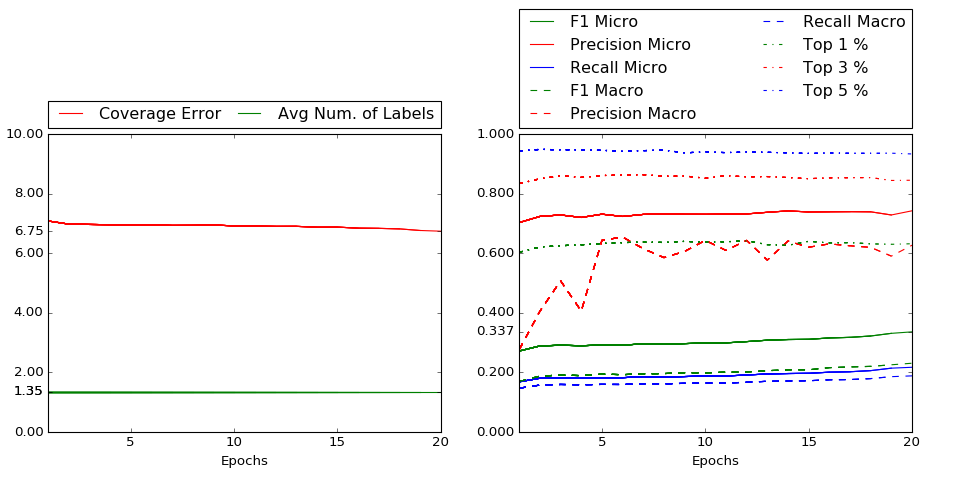

doc2vec_size_1000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_{}_iter_1000_reg_0.1


In [47]:
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()
print placeholder_model_name + "_" + GLOBAL_VARS.SVM_MODEL_NAME

for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
    try:
        model_name = placeholder_model_name.format(epoch)
        metrics = pickle.load(open(os.path.join(doc2vec_model_save_location, model_name, GLOBAL_VARS.SVM_MODEL_NAME, METRICS)))
        graph.add_metrics_to_graph(metrics, epoch)
    except IOError:
        break

In [119]:
[metric['coverage_error'] for metric in epoch_metrics]

[6.0518029456576938,
 4.3138649060436771,
 3.7851701371254443,
 1.4565769426104622,
 1.3819197562214323]